In [1]:
import os
import glob
import re
import datetime
import glob
from datetime import date, time, timedelta
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import chain
from cv2 import VideoCapture, CAP_PROP_FRAME_COUNT, CAP_PROP_FPS, CAP_PROP_POS_FRAMES
import ffmpeg
from imutils.video import FileVideoStream
import time
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import Span, DatetimeTicker, DatetimeTickFormatter
from tsmoothie.smoother import *
from utils import load_diffs, load_slide_changes, load_intervals, filter_video

sns.set()
output_notebook()

Loading BokehJS ...

# Paths

In [2]:
#meeting_id = 160320
#meeting_id = 220120
meeting_id = 170127
#meeting_id = 83512718053

In [3]:
masked = True

In [4]:
video_path = glob.glob(f'zoom_data/{meeting_id}/*.mp4')[0]
print(video_path)
if masked is None:
    diff_path = f'diff_data/diffs_{meeting_id}_cossim.csv'
    diff_path_masked = f'diff_data/diffs_{meeting_id}_pct_masked_cossim.csv'
elif masked:
    diff_path = f'diff_data/diffs_{meeting_id}_pct_masked_cossim.csv'
else:
    diff_path = f'diff_data/diffs_{meeting_id}_cossim.csv'
sc_labels = f'slide_change_labels/{meeting_id}.csv'
interval_path = 'interval_data/intervals.csv'

zoom_data/170127/GMT20210614-170127_Recording_2350x1322.mp4


# Load FPS, Diffs, and Slide Change Labels

In [5]:
vidcap = VideoCapture(video_path)
fps = vidcap.get(CAP_PROP_FPS)
ddiffs = load_diffs(diff_path, fps)
sldf = load_slide_changes(sc_labels)
idf = load_intervals(interval_path, meeting_id=meeting_id)

In [6]:
sldf.head()

,change_time,note,change_time_dt
0,0:00:57,NaN,1970-01-01 00:00:57
1,0:1:29,NaN,1970-01-01 00:01:29
2,0:2:07,NaN,1970-01-01 00:02:07
3,0:3:35,NaN,1970-01-01 00:03:35
4,0:5:37,NaN,1970-01-01 00:05:37


In [7]:
idf.head()

,meeting_id,start,stop,start_dt,stop_dt
0,170127,0:01,36:29,1970-01-01 00:00:01,1970-01-01 00:36:29
1,170127,38:13,52:58,1970-01-01 00:38:13,1970-01-01 00:52:58
2,170127,59:53,1:39:16,1970-01-01 00:59:53,1970-01-01 01:39:16
3,170127,1:47:11,1:58:58,1970-01-01 01:47:11,1970-01-01 01:58:58


# Visualize

In [8]:
ddiffs = filter_video(ddiffs, sldf, idf)
ddiffs_cos = ddiffs.cos_sim_diff.to_numpy()
ddiffs_time = ddiffs.elapsed_dt

In [9]:
ddiffs.head()

,meeting_id,elapsed_dt,l1_diff,l2_diff,cos_sim_diff
0,170127,1970-01-01 00:00:01,0.0,0.000000,0.000000e+00
1,170127,1970-01-01 00:00:02,13160402.0,57322.628935,4.460693e-05
2,170127,1970-01-01 00:00:03,1877100.0,3875.137626,0.000000e+00
3,170127,1970-01-01 00:00:04,0.0,0.000000,0.000000e+00
4,170127,1970-01-01 00:00:05,3760052.0,30732.921989,6.226180e-07


### Cosine Similarly - naive

In [12]:
p = figure(plot_width=1500, plot_height=400, x_axis_type='datetime')
p.line(ddiffs_time, ddiffs_cos, line_width=2, line_alpha=0.5)
median = Span(location=np.median(ddiffs_cos), dimension='width', line_color='black', line_dash='dashed', line_width=1)
sdev = Span(location=np.median(ddiffs_cos) + np.std(ddiffs_cos), dimension='width', line_color='red', line_dash='dashed', line_width=1)
sdev2 = Span(location=np.median(ddiffs_cos) + 2 * np.std(ddiffs_cos), dimension='width', line_color='red', line_dash='dashed', line_width=1)
sdev3 = Span(location=np.median(ddiffs_cos) + 3 * np.std(ddiffs_cos), dimension='width', line_color='red', line_dash='dashed', line_width=1)
p.add_layout(median)
p.add_layout(sdev)
p.add_layout(sdev2)
p.add_layout(sdev3)

if sldf is not None:
    for sc in sldf.change_time_dt:
        c = Span(location=sc, dimension='height', line_color='black', line_width=0.5)
        p.add_layout(c)

p.title.text = "Inverse cosine similarity - naive"
p.title.text_font_size = '15pt'
p.xaxis.ticker = DatetimeTicker(desired_num_ticks=30, num_minor_ticks=10)
p.xaxis.formatter = DatetimeTickFormatter(minutes='%M', seconds='%M:%S')
p.xaxis.major_label_orientation = "vertical"
show(p)

### Cosine Similarly - stdev band

In [10]:
window = 10
com = 0.8
ddiffs['rmean'] = ddiffs.cos_sim_diff.rolling(window).mean()
ddiffs['band'] = ddiffs['rmean'] + ddiffs.cos_sim_diff.rolling(window).std() * 2.8

#ddiffs['rmean'] = ddiffs.cos_sim.ewm(com=com).mean()
#ddiffs['band'] = rmean + ddiffs.cos_sim.ewm(com=com).std() * 1

ddiffs['slide_change'] = ddiffs.cos_sim_diff > ddiffs.band
signals = ddiffs.query("slide_change")

In [11]:
p = figure(plot_width=1000, plot_height=400, x_axis_type='datetime')
p.line(ddiffs_time, ddiffs_cos, line_width=2, line_alpha=0.5)
#p.line(ddiffs_time, ddiffs.rmean, line_width=2, line_alpha=0.25, line_color='black')
p.line(ddiffs_time, ddiffs.band, line_width=2, line_alpha=0.25, line_color='green')
p.circle(signals.elapsed_dt, signals.cos_sim_diff, alpha=0.25, color='red')

if sldf is not None:
    for sc in sldf.change_time_dt:
        c = Span(location=sc, dimension='height', line_color='black', line_width=0.5)
        p.add_layout(c)

p.title.text = "Inverse cosine similarity - MA"
p.title.text_font_size = '15pt'
p.xaxis.ticker = DatetimeTicker(desired_num_ticks=30, num_minor_ticks=10)
p.xaxis.formatter = DatetimeTickFormatter(minutes='%M', seconds='%M:%S')
p.xaxis.major_label_orientation = "vertical"
show(p)

### Cosine Similarly - differencing / autoregressive

In [15]:
#ddiffs['cos_sim_diff'] = ddiffs.cos_sim.diff()
ddiffs['cos_sim_diff'] = np.maximum(ddiffs.cos_sim.diff(), 0)

AttributeError: 'DataFrame' object has no attribute 'cos_sim'

In [36]:
ddiffs.cos_sim_diff.quantile(q=0.986555)

9.051843428612497e-05

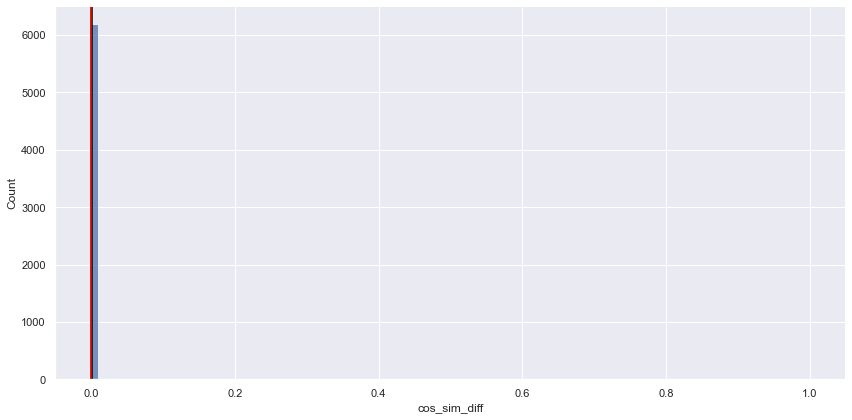

In [37]:
quantile = 0.986555
threshold = ddiffs.cos_sim_diff.quantile(q=quantile)
g = sns.displot(x=ddiffs.cos_sim_diff, kind='hist', bins=100, height=6, aspect=2)
g.ax.axvline(ddiffs.cos_sim_diff.median(), c='green');
g.ax.axvline(ddiffs.cos_sim_diff.mean(), c='black');
g.ax.axvline(threshold, c='red')
#plt.xlim(0, 0.01);

In [108]:
signals2 = ddiffs.loc[ddiffs.cos_sim_diff >= threshold, :]

In [13]:
signals2 = ddiffs.loc[ddiffs.cos_sim_diff >= ddiffs.cos_sim_diff.mean(), :]

In [61]:
ddiffs.cos_sim_diff.mean()

0.0009354181002539306

In [61]:
ddiffs.cos_sim_diff.mean()

0.0009354181002539306

In [14]:
p = figure(plot_width=1400, plot_height=500, x_axis_type='datetime')
p.line(ddiffs_time, ddiffs.cos_sim_diff, line_width=2, line_alpha=0.5)
#p.line(ddiffs_time, ddiffs.rmean, line_width=2, line_alpha=0.25, line_color='black')
#p.line(ddiffs_time, ddiffs.band, line_width=2, line_alpha=0.25, line_color='green')
p.circle(signals2.elapsed_dt, signals2.cos_sim_diff, alpha=0.25, color='red')
median = Span(location=ddiffs.cos_sim_diff.median(), dimension='width', line_color='black', line_dash='dashed', line_width=1)
p.add_layout(median)


if sldf is not None:
    for sc in sldf.change_time_dt:
        c = Span(location=sc, dimension='height', line_color='black', line_width=0.5)
        p.add_layout(c)


p.title.text = "Inverse cosine similarity - diff"
p.title.text_font_size = '15pt'
p.xaxis.ticker = DatetimeTicker(desired_num_ticks=30, num_minor_ticks=10)
p.xaxis.formatter = DatetimeTickFormatter(minutes='%H:%M:%S', minsec='%H:%M:%S', hourmin='%H:%M:%S', seconds='%H:%M:%S', hours='%H')
p.xaxis.major_label_orientation = "vertical"
show(p)

### Cosine Similarly - stdev differencing / autoregressive

In [17]:
window = 10
ddiffs['stdev'] = ddiffs.cos_sim.rolling(window).std()
#ddiffs['stdev_diff'] = ddiffs['stdev'].diff()
ddiffs['stdev_diff'] = np.maximum(ddiffs['stdev'].diff(), 0)
diff_mean = ddiffs.stdev_diff.mean()
signals2 = ddiffs.loc[ddiffs.cos_sim_diff >= diff_mean, :]

AttributeError: 'DataFrame' object has no attribute 'cos_sim'

In [75]:
p = figure(plot_width=1500, plot_height=400, x_axis_type='datetime')
p.line(ddiffs_time, ddiffs.stdev_diff, line_width=2, line_alpha=0.5)
#p.line(ddiffs_time, ddiffs.cos_sim_diff, line_width=2, line_alpha=0.5)
#p.line(ddiffs_time, ddiffs.rmean, line_width=2, line_alpha=0.25, line_color='black')
#p.line(ddiffs_time, ddiffs.band, line_width=2, line_alpha=0.25, line_color='green')
p.circle(signals2.elapsed_dt, signals2.stdev_diff, alpha=0.25, color='red')
mean = Span(location=diff_mean, dimension='width', line_color='black', line_dash='dashed', line_width=1)
p.add_layout(mean)


if sldf is not None:
    for sc in sldf.change_time_dt:
        c = Span(location=sc, dimension='height', line_color='black', line_width=0.5)
        p.add_layout(c)


p.title.text = "Inverse cosine similarity - stdev diff"
p.title.text_font_size = '15pt'
p.xaxis.ticker = DatetimeTicker(desired_num_ticks=30, num_minor_ticks=10)
p.xaxis.formatter = DatetimeTickFormatter(minutes='%M', seconds='%M:%S')
p.xaxis.major_label_orientation = "vertical"
show(p)

### Cosine Similarly - Gaussian smoothing

In [130]:
#smoother = GaussianSmoother(n_knots=100, sigma=1)
smoother = GaussianSmoother(n_knots=1, sigma=1)
smoother.smooth(ddiffs_cos)
low, up = smoother.get_intervals('confidence_interval')
#low, up = smoother.get_intervals('confidence_interval', n_sigma=2)
signals2 = ddiffs.loc[ddiffs.cos_sim_diff >= up.ravel(), :]

In [131]:
p = figure(plot_width=1500, plot_height=400, x_axis_type='datetime')
p.line(ddiffs_time, ddiffs_cos, line_width=2, line_alpha=0.5)
p.line(ddiffs_time, up.ravel(), line_width=2, line_alpha=0.5, line_color='black')
#p.line(ddiffs_time[window:], up.ravel(), line_width=2, line_alpha=0.5, line_color='black')
#p.line(ddiffs_time, ddiffs.rmean, line_width=2, line_alpha=0.25, line_color='black')
#p.line(ddiffs_time, ddiffs.band, line_width=2, line_alpha=0.25, line_color='green')
p.circle(signals2.elapsed_dt, signals2.cos_sim_diff, alpha=0.25, color='red')
#median = Span(location=ddiffs.cos_sim_diff.median(), dimension='width', line_color='black', line_dash='dashed', line_width=1)
#p.add_layout(median)


if sldf is not None:
    for sc in sldf.change_time_dt:
        c = Span(location=sc, dimension='height', line_color='black', line_width=0.5)
        p.add_layout(c)


p.title.text = "Inverse cosine similarity - Gaussian smoothing"
p.title.text_font_size = '15pt'
p.xaxis.ticker = DatetimeTicker(desired_num_ticks=30, num_minor_ticks=10)
p.xaxis.formatter = DatetimeTickFormatter(minutes='%M', seconds='%M:%S')
p.xaxis.major_label_orientation = "vertical"
show(p)

In [132]:
smoother = KalmanSmoother(component='level'
                          ,component_noise={'level':0.5}
                         )
smoother.smooth(ddiffs_cos)
low, up = smoother.get_intervals('kalman_interval')
#low, up = smoother.get_intervals('kalman_interval', confidence=0.5)
signals2 = ddiffs.loc[ddiffs.cos_sim_diff >= up.ravel(), :]

In [133]:
p = figure(plot_width=1500, plot_height=400, x_axis_type='datetime')
p.line(ddiffs_time, ddiffs_cos, line_width=2, line_alpha=0.5)
p.line(ddiffs_time, up.ravel(), line_width=2, line_alpha=0.5, line_color='black')
#p.line(ddiffs_time[window:], up.ravel(), line_width=2, line_alpha=0.5, line_color='black')
#p.line(ddiffs_time, ddiffs.rmean, line_width=2, line_alpha=0.25, line_color='black')
#p.line(ddiffs_time, ddiffs.band, line_width=2, line_alpha=0.25, line_color='green')
p.circle(signals2.elapsed_dt, signals2.cos_sim_diff, alpha=0.25, color='red')
#median = Span(location=ddiffs.cos_sim_diff.median(), dimension='width', line_color='black', line_dash='dashed', line_width=1)
#p.add_layout(median)


if sldf is not None:
    for sc in sldf.change_time_dt:
        c = Span(location=sc, dimension='height', line_color='black', line_width=0.5)
        p.add_layout(c)


p.title.text = "Inverse cosine similarity - Kalman Filter"
p.title.text_font_size = '15pt'
p.xaxis.ticker = DatetimeTicker(desired_num_ticks=30, num_minor_ticks=10)
p.xaxis.formatter = DatetimeTickFormatter(minutes='%M', seconds='%M:%S')
p.xaxis.major_label_orientation = "vertical"
show(p)

## Philippe Notes

* Annotate rest of videos
* Test this autoregressive method on rest of the videos
* If successful, try out on corner cases (blurred, translated, etc...)

82               NaN
83     -4.719957e-06
84     -4.374346e-06
85     -4.766205e-06
86     -1.665277e-10
            ...     
2043    7.380545e-07
2044    3.186563e-05
2045    4.945095e-09
2046    2.570800e-01
2047   -2.549656e-01
Name: cos_sim, Length: 1966, dtype: float64